# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'autoencoder'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_fc_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp   rain_1h   snow_1h     clouds_all
count   341736.000000  341736.000000  341736.0  341736.0  341736.000000
mean      3297.371241     282.815572       0.0       0.0      37.300382
std       1943.009003      12.227262       0.0       0.0      39.207268
min          0.000000     243.858856       0.0       0.0       0.000000
25%       1351.575958     273.691193       0.0       0.0       0.000000
50%       3630.303101     284.637863       0.0       0.0      20.491416
75%       4942.487427     292.859795       0.0       0.0      85.235302
max       7696.179688     309.678741       0.0       0.0     104.347099


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  28511.000000
mean       3313.74238    282.688768      0.061611      0.000250     42.122795
std        1971.53206     12.367361      0.678185      0.008298     39.316195
min         

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.13145430358126758
Training Loss: 0.08327196711674333
Training Loss: 0.06545656248927116
Validation Loss: 0.05184060883488548
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05466958869248629
Training Loss: 0.050813169591128825
Training Loss: 0.04952523828484118
Validation Loss: 0.04513409897015336
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04647692705504596
Training Loss: 0.04315120765008032
Training Loss: 0.04083655645139515
Validation Loss: 0.0361481648608205
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03657150295563042
Training Loss: 0.032896511731669305
Training Loss: 0.030397462584078314
Validation Loss: 0.026489053151748154
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.026988303042016923
Training Loss: 0.024579732338897885
Training

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:25<30:49, 205.51s/it]

Epoch: 1
Training Loss: 0.2292486983910203
Training Loss: 0.15347233604639768
Training Loss: 0.11345677968114615
Validation Loss: 0.08436936131688987
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07819454370066524
Training Loss: 0.06370444763451814
Training Loss: 0.059538753498345615
Validation Loss: 0.053321970773212025
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05609009247273207
Training Loss: 0.05318434115499258
Training Loss: 0.05116597623564303
Validation Loss: 0.045391756455215176
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04796953008510172
Training Loss: 0.04458001608029008
Training Loss: 0.041501038316637276
Validation Loss: 0.03556717505280891
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03745094634592533
Training Loss: 0.03369025973603129
Training L

 20%|██        | 2/10 [06:52<27:31, 206.50s/it]

Epoch: 1
Training Loss: 0.21534262388944625
Training Loss: 0.15618117995560168
Training Loss: 0.12399917986243963
Validation Loss: 0.09104538252681829
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09055724080651999
Training Loss: 0.0778324843198061
Training Loss: 0.07601877517998218
Validation Loss: 0.0702668217460761
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07334675639867783
Training Loss: 0.07052981097251176
Training Loss: 0.07012496864423155
Validation Loss: 0.06556729260790214
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06803937789052725
Training Loss: 0.06543364400044084
Training Loss: 0.06479970060288906
Validation Loss: 0.0605328766984886
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.06260743752121925
Training Loss: 0.06002537418156862
Training Loss: 0

 30%|███       | 3/10 [10:18<24:04, 206.40s/it]

Training Loss: 0.006474529906408861
Validation Loss: 0.003791792006912024
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.41186952494084833
Training Loss: 0.31144462786614896
Training Loss: 0.23839793153107167
Validation Loss: 0.15363935230488188
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.13989964321255685
Training Loss: 0.08957063114270568
Training Loss: 0.06693267118185758
Validation Loss: 0.04958665601155731
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05237032137811184
Training Loss: 0.04906103877350688
Training Loss: 0.04787019154988229
Validation Loss: 0.04447051219307305
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.045586007218807935
Training Loss: 0.04339593729935586
Training Loss: 0.04175447864457965
Validation Loss: 0.038479238057906706
Validation Accur

 40%|████      | 4/10 [13:45<20:38, 206.43s/it]

Training Loss: 0.005755379046313465
Validation Loss: 0.003263691748921456
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11914786418899893
Training Loss: 0.08989881873130798
Training Loss: 0.07932112570852042
Validation Loss: 0.0698681671297952
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07382284911349415
Training Loss: 0.07025158692151308
Training Loss: 0.06782931484282016
Validation Loss: 0.06117651251594672
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06449850901961326
Training Loss: 0.060938708689063786
Training Loss: 0.058406323231756686
Validation Loss: 0.052328040886126206
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05448445506393909
Training Loss: 0.05071018993854523
Training Loss: 0.047898928401991725
Validation Loss: 0.04225831995770503
Validation Accu

 50%|█████     | 5/10 [17:12<17:13, 206.71s/it]

Training Loss: 0.005784459189744667
Validation Loss: 0.003307985930619866
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.22237679440528155
Training Loss: 0.15236600082367657
Training Loss: 0.1123185182735324
Validation Loss: 0.0781582903242513
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07532366848550737
Training Loss: 0.0603836006578058
Training Loss: 0.054111654330044986
Validation Loss: 0.04384766554648287
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05055562512949109
Training Loss: 0.048224672144278884
Training Loss: 0.0449829291831702
Validation Loss: 0.0367142776383108
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.042162460759282115
Training Loss: 0.039630705313757064
Training Loss: 0.03604646421968937
Validation Loss: 0.028920735379032204
Validation Accurac

 60%|██████    | 6/10 [20:38<13:45, 206.28s/it]

Epoch: 1
Training Loss: 0.31447374530136585
Training Loss: 0.23592617467045784
Training Loss: 0.1919391915947199
Validation Loss: 0.1471681372168359
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1366914350911975
Training Loss: 0.1005255812779069
Training Loss: 0.0819757517799735
Validation Loss: 0.06184990055273088
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0640979839488864
Training Loss: 0.057967515401542186
Training Loss: 0.055599354384467004
Validation Loss: 0.04887065931819798
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.052146725030615924
Training Loss: 0.04905484838411212
Training Loss: 0.04633278530091047
Validation Loss: 0.040267937303928844
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.042329170498996975
Training Loss: 0.038974963994696736
Training Loss

 70%|███████   | 7/10 [24:03<10:18, 206.15s/it]

Training Loss: 0.0052567849273327735
Validation Loss: 0.002870370567190262
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4146188522875309
Training Loss: 0.2680022932589054
Training Loss: 0.16845780543982983
Validation Loss: 0.10223428377609574
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09087620289996266
Training Loss: 0.07311459580436348
Training Loss: 0.06996360469609499
Validation Loss: 0.06364876241161582
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0681205572374165
Training Loss: 0.06601518442854286
Training Loss: 0.06485149621963501
Validation Loss: 0.05907474077317152
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06325562715530396
Training Loss: 0.06099578097462654
Training Loss: 0.0593636635132134
Validation Loss: 0.05344494047124734
Validation Accuracy: 

 80%|████████  | 8/10 [27:29<06:51, 205.94s/it]

**************************************************
Epoch: 1
Training Loss: 0.09502113219350576
Training Loss: 0.07161808228120208
Training Loss: 0.06373452425003051
Validation Loss: 0.05549835175108374
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.058104544635862114
Training Loss: 0.054334569964557884
Training Loss: 0.05198818470351398
Validation Loss: 0.04590269770431385
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04751501164399088
Training Loss: 0.043554477607831356
Training Loss: 0.04038690485060215
Validation Loss: 0.03455553199635463
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03555230215191841
Training Loss: 0.03188635110855102
Training Loss: 0.02872796565759927
Validation Loss: 0.024160690668426202
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.02514688574

 90%|█████████ | 9/10 [30:55<03:25, 205.85s/it]

Epoch: 1
Training Loss: 0.5026608310639858
Training Loss: 0.39217217966914175
Training Loss: 0.31789714492857457
Validation Loss: 0.23670476842462346
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.21162731308490038
Training Loss: 0.14247654359787704
Training Loss: 0.10183185851201415
Validation Loss: 0.06350153609273139
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06372854772955179
Training Loss: 0.05436440235003829
Training Loss: 0.05244145849719643
Validation Loss: 0.04745057154070126
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04956642288714647
Training Loss: 0.04701839502900839
Training Loss: 0.045006966842338444
Validation Loss: 0.0403326814471001
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04147849620319903
Training Loss: 0.038639313522726294
Training Loss

100%|██████████| 10/10 [34:21<00:00, 205.95s/it]

Training Loss: 0.005861294029746205
Validation Loss: 0.003425190802088028
Validation Accuracy: 0.0
**************************************************


100%|██████████| 10/10 [34:21<00:00, 206.13s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.26799303479492664
Training Loss: 0.20990593083202838
Training Loss: 0.14010058142244816
Validation Loss: 0.08577977543633976
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06969297718256712
Training Loss: 0.06123011004179716
Training Loss: 0.05785145822912455
Validation Loss: 0.056861187090699594
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.055181442275643346
Training Loss: 0.053571699876338245
Training Loss: 0.05044915188103914
Validation Loss: 0.048503293749991426
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04677301725372672
Training Loss: 0.04457228615880013
Training Loss: 0.04130879335105419
Validation Loss: 0.03888046861825029
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03729436447843909
Training Loss: 0.035007167169824244
Training

 10%|█         | 1/10 [03:27<31:11, 207.93s/it]

Validation Loss: 0.0025803515484185075
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08288745453581214
Training Loss: 0.074304433260113
Training Loss: 0.06987729379907251
Validation Loss: 0.06862353297013245
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06605898316949606
Training Loss: 0.064022755054757
Training Loss: 0.060569595564156774
Validation Loss: 0.057837266391247845
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05513124322518706
Training Loss: 0.05214610199443996
Training Loss: 0.04824955854564905
Validation Loss: 0.04456624420087659
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04220123744569719
Training Loss: 0.03918480495922268
Training Loss: 0.035645666876807806
Validation Loss: 0.0322591732413079
Validation Accuracy: 0.0
******************************

 20%|██        | 2/10 [06:57<27:50, 208.81s/it]

Validation Loss: 0.0028700574770114604
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2554911184310913
Training Loss: 0.21135311804711818
Training Loss: 0.1583061885088682
Validation Loss: 0.12118830736935808
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1035859952121973
Training Loss: 0.08395234972238541
Training Loss: 0.07011580398306251
Validation Loss: 0.06700582603474012
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06493029341101647
Training Loss: 0.06414879374206066
Training Loss: 0.06156036078929901
Validation Loss: 0.06064479915278681
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.058590105082839725
Training Loss: 0.05704073888249695
Training Loss: 0.053565200716257096
Validation Loss: 0.051378072501066026
Validation Accuracy: 0.0
****************************

 30%|███       | 3/10 [10:26<24:21, 208.80s/it]

Validation Loss: 0.0035261419010505584
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4598026625812054
Training Loss: 0.39679266028106214
Training Loss: 0.31312607012689114
Validation Loss: 0.23513045136848193
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.18701400879770516
Training Loss: 0.11838552378118038
Training Loss: 0.07364368261769413
Validation Loss: 0.060134507506416086
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05599725347943604
Training Loss: 0.05291077789850533
Training Loss: 0.04807221178896725
Validation Loss: 0.046002660469895
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04331773854792118
Training Loss: 0.04100051614455879
Training Loss: 0.03728569848462939
Validation Loss: 0.035729412052236245
Validation Accuracy: 0.0
*****************************

 40%|████      | 4/10 [13:56<20:55, 209.31s/it]

Validation Loss: 0.003693854137391815
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12367158506065606
Training Loss: 0.09538400301709771
Training Loss: 0.07874385301023722
Validation Loss: 0.07384046723835924
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07065828818827867
Training Loss: 0.06875015672296286
Training Loss: 0.06637077471241355
Validation Loss: 0.06464757362192267
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06262602394446731
Training Loss: 0.061051667500287295
Training Loss: 0.05881429789587855
Validation Loss: 0.0569053040712737
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05516469279304147
Training Loss: 0.0534773659799248
Training Loss: 0.05116973373107612
Validation Loss: 0.048848481179120835
Validation Accuracy: 0.0
*****************************

 50%|█████     | 5/10 [17:25<17:26, 209.32s/it]

Validation Loss: 0.003542604073986746
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.31339340262115
Training Loss: 0.23740695334970952
Training Loss: 0.16265255603939294
Validation Loss: 0.11357928820875253
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09554436132311821
Training Loss: 0.0794837455637753
Training Loss: 0.07146460138261318
Validation Loss: 0.07123366232668416
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06884023655205965
Training Loss: 0.06824174921959639
Training Loss: 0.06522225506603718
Validation Loss: 0.06510626409579529
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06270136954262853
Training Loss: 0.0618719391990453
Training Loss: 0.05892213832587004
Validation Loss: 0.05849313254604179
Validation Accuracy: 0.0
**********************************

 60%|██████    | 6/10 [20:55<13:57, 209.41s/it]

Validation Loss: 0.003357702456453941
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14474970284849406
Training Loss: 0.11537657858803868
Training Loss: 0.08901927284896374
Validation Loss: 0.07859949633646547
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07490004677325487
Training Loss: 0.07320536620914936
Training Loss: 0.07082241892814636
Validation Loss: 0.06999522642222013
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06853696726262569
Training Loss: 0.06752120630815625
Training Loss: 0.0655137419141829
Validation Loss: 0.06439042719227545
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06309849020093679
Training Loss: 0.06193971975706518
Training Loss: 0.05993739474564791
Validation Loss: 0.05826587910146526
Validation Accuracy: 0.0
******************************

 70%|███████   | 7/10 [24:24<10:28, 209.40s/it]

Validation Loss: 0.0036638340326758585
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.35781688429415226
Training Loss: 0.2847414759546518
Training Loss: 0.2081135391071439
Validation Loss: 0.14658499730939276
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11533252825960517
Training Loss: 0.08152299644425512
Training Loss: 0.06504999289289116
Validation Loss: 0.06343265666804287
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0606618938408792
Training Loss: 0.06021534016355872
Training Loss: 0.057026184909045693
Validation Loss: 0.057039280432496176
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054701414685696365
Training Loss: 0.05389295492321253
Training Loss: 0.05066628459841013
Validation Loss: 0.04981912191161949
Validation Accuracy: 0.0
****************************

 80%|████████  | 8/10 [27:53<06:58, 209.41s/it]

Validation Loss: 0.003641058832768016
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08738390009850264
Training Loss: 0.07767786322161556
Training Loss: 0.0733176319859922
Validation Loss: 0.07264441496619348
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07014258027076721
Training Loss: 0.06856327883899212
Training Loss: 0.06517884524539114
Validation Loss: 0.06326371002314465
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06051460418850183
Training Loss: 0.057833385448902846
Training Loss: 0.05350334221497178
Validation Loss: 0.05019434681685453
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04747259550727904
Training Loss: 0.044062169119715694
Training Loss: 0.03971734980121255
Validation Loss: 0.03612153737523248
Validation Accuracy: 0.0
****************************

 90%|█████████ | 9/10 [31:23<03:29, 209.37s/it]

Validation Loss: 0.003311127384671983
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08266917198896408
Training Loss: 0.06911155117675662
Training Loss: 0.05962848545983434
Validation Loss: 0.05710290977208132
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05482303250581026
Training Loss: 0.05333246934227645
Training Loss: 0.049972866494208575
Validation Loss: 0.047785054379550926
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04541149022057653
Training Loss: 0.04279415626078844
Training Loss: 0.03867092501372099
Validation Loss: 0.03550991060191326
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03340893993154168
Training Loss: 0.030666815717704594
Training Loss: 0.0273026310140267
Validation Loss: 0.024833266094871118
Validation Accuracy: 0.0
**************************

100%|██████████| 10/10 [34:52<00:00, 209.29s/it]


Validation Loss: 0.003648286801762879
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.46319680146873
Training Loss: 0.3513029595836997
Training Loss: 0.27977054096758364
Validation Loss: 0.17813762826740406
Validation Accuracy: 0.0877808988764045
**************************************************
Epoch: 2
Training Loss: 0.13864984806627034
Training Loss: 0.07669134989148006
Training Loss: 0.06946284654550254
Validation Loss: 0.060813385302598555
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.056825466863811014
Training Loss: 0.053380514876917
Training Loss: 0.05778562389314175
Validation Loss: 0.055509092056014564
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05199162468779832
Training Loss: 0.049017340186983345
Training Loss: 0.05241599593311548
Validation Loss: 0.050191205978560985
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04686880961759016
Training Loss: 0.04389813920948654

 10%|█         | 1/10 [03:30<31:31, 210.17s/it]

Validation Loss: 7.488727145898614e-05
Validation Accuracy: 0.0702247191011236
**************************************************
Epoch: 1
Training Loss: 0.32609655782580377
Training Loss: 0.20665806390345096
Training Loss: 0.1419255573209375
Validation Loss: 0.08765663522599118
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07363508716225624
Training Loss: 0.05795313835609704
Training Loss: 0.06030548152513802
Validation Loss: 0.05861127781524752
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0555778981000185
Training Loss: 0.05284082598052919
Training Loss: 0.05540403552353382
Validation Loss: 0.05437690204825629
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0511993880616501
Training Loss: 0.04855707806535065
Training Loss: 0.05062406519427896
Validation Loss: 0.04955686318028844
Validation Accuracy: 0.0
****************

 20%|██        | 2/10 [07:00<28:00, 210.03s/it]

Validation Loss: 9.770718418039497e-05
Validation Accuracy: 0.12289325842696629
**************************************************
Epoch: 1
Training Loss: 0.06076240804046393
Training Loss: 0.056388432793319225
Training Loss: 0.05744657861068845
Validation Loss: 0.05615203540897771
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0523445313051343
Training Loss: 0.04822463855147362
Training Loss: 0.04845275606028736
Validation Loss: 0.04609164407246568
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04234950332902372
Training Loss: 0.03790320529602468
Training Loss: 0.03695725426077843
Validation Loss: 0.03370872358111351
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.030319114127196373
Training Loss: 0.026021135980263354
Training Loss: 0.024535432709380984
Validation Loss: 0.021351152620267835
Validation Accuracy: 0.0
********

 30%|███       | 3/10 [10:30<24:30, 210.09s/it]

Validation Loss: 6.64960073796526e-05
Validation Accuracy: 0.0877808988764045
**************************************************
Epoch: 1
Training Loss: 0.20891592305153608
Training Loss: 0.13788685437291862
Training Loss: 0.10570238150656223
Validation Loss: 0.08196611010752032
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07168320969678461
Training Loss: 0.05933031349442899
Training Loss: 0.05948264635168016
Validation Loss: 0.056753923352598476
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05339712098240852
Training Loss: 0.049003495573997496
Training Loss: 0.050315964017063376
Validation Loss: 0.04828730128245073
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04536451277323067
Training Loss: 0.04058245059568435
Training Loss: 0.04017015636898577
Validation Loss: 0.03676794812585531
Validation Accuracy: 0.0
***********

 40%|████      | 4/10 [14:03<21:07, 211.19s/it]

Validation Loss: 0.00011049935816894443
Validation Accuracy: 0.24578651685393257
**************************************************
Epoch: 1
Training Loss: 0.12568531858734786
Training Loss: 0.08734140557702631
Training Loss: 0.07911948510445654
Validation Loss: 0.07065506354811486
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06639269927516579
Training Loss: 0.06073510247282684
Training Loss: 0.06288514274172485
Validation Loss: 0.06189675026395348
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058769625807181
Training Loss: 0.054704523235559466
Training Loss: 0.0562188568059355
Validation Loss: 0.0549037792102507
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05176056281663478
Training Loss: 0.047342397794127467
Training Loss: 0.047668782016262415
Validation Loss: 0.04481573610074734
Validation Accuracy: 0.0
************

 50%|█████     | 5/10 [18:07<18:36, 223.26s/it]

Validation Loss: 0.0001813088319670825
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.26908256351947785
Training Loss: 0.17374100521206856
Training Loss: 0.12392544124275445
Validation Loss: 0.07903123397924257
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06587649870663881
Training Loss: 0.05086699750740081
Training Loss: 0.051114225662313405
Validation Loss: 0.04866843951049815
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0463262801617384
Training Loss: 0.04359148853458464
Training Loss: 0.04524268184322864
Validation Loss: 0.043827794900352365
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04143614975153469
Training Loss: 0.038826160719618204
Training Loss: 0.0399537554429844
Validation Loss: 0.038454307023477685
Validation Accuracy: 0.0
**************************

 60%|██████    | 6/10 [22:18<15:30, 232.60s/it]

Validation Loss: 0.00011815246612927746
Validation Accuracy: 0.1404494382022472
**************************************************
Epoch: 1
Training Loss: 0.423232104703784
Training Loss: 0.2679158175364137
Training Loss: 0.1746002635359764
Validation Loss: 0.09651752176244607
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08018592119216919
Training Loss: 0.05744230300188065
Training Loss: 0.05821157587692141
Validation Loss: 0.05550269796146771
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05293436213396489
Training Loss: 0.049725236780941484
Training Loss: 0.05169403394684195
Validation Loss: 0.050425681044881265
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04773036615923047
Training Loss: 0.044319221135228876
Training Loss: 0.04534483583644033
Validation Loss: 0.043437524060352464
Validation Accuracy: 0.0
************

 70%|███████   | 7/10 [26:29<11:55, 238.57s/it]

Validation Loss: 6.931897906326228e-05
Validation Accuracy: 0.1404494382022472
**************************************************
Epoch: 1
Training Loss: 0.22060230936855077
Training Loss: 0.1715247732400894
Training Loss: 0.1376078696642071
Validation Loss: 0.09530612466113872
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07505607400089502
Training Loss: 0.051576787314843386
Training Loss: 0.0476211242377758
Validation Loss: 0.04424179236540634
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04181766632013023
Training Loss: 0.037409441547933964
Training Loss: 0.03756043422035873
Validation Loss: 0.03497564664968614
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03277952701319009
Training Loss: 0.029006605508038776
Training Loss: 0.028700713869184255
Validation Loss: 0.02628837743240377
Validation Accuracy: 0.0
************

 80%|████████  | 8/10 [30:44<08:07, 243.73s/it]

Validation Loss: 8.049825441191664e-05
Validation Accuracy: 0.175561797752809
**************************************************
Epoch: 1
Training Loss: 0.3548054592311382
Training Loss: 0.2673355854675174
Training Loss: 0.2297498022764921
Validation Loss: 0.16912432693028717
Validation Accuracy: 0.0175561797752809
**************************************************
Epoch: 2
Training Loss: 0.14447290692478418
Training Loss: 0.0906189585966058
Training Loss: 0.07702909500338137
Validation Loss: 0.060084365418159896
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05702523129293695
Training Loss: 0.051249965438619254
Training Loss: 0.05511751252692193
Validation Loss: 0.051707999472077305
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.049491969366790727
Training Loss: 0.045617568865418436
Training Loss: 0.04831907212268561
Validation Loss: 0.045430090958566476
Validation Accuracy: 0

 90%|█████████ | 9/10 [34:55<04:06, 246.19s/it]

Validation Loss: 0.00018082282814462774
Validation Accuracy: 0.0702247191011236
**************************************************
Epoch: 1
Training Loss: 0.683462620228529
Training Loss: 0.5143584702908993
Training Loss: 0.4062305615097284
Validation Loss: 0.29426853220616833
Validation Accuracy: 0.2633426966292135
**************************************************
Epoch: 2
Training Loss: 0.24912343584001065
Training Loss: 0.15952511331997812
Training Loss: 0.11662242755293846
Validation Loss: 0.07696480117738247
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06650474824011327
Training Loss: 0.05334077273961157
Training Loss: 0.05498817914165557
Validation Loss: 0.053123342333717294
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05084321698639542
Training Loss: 0.048397832335904244
Training Loss: 0.050419600903987886
Validation Loss: 0.04946747977872578
Validation Accuracy: 0.

100%|██████████| 10/10 [39:11<00:00, 235.17s/it]


Validation Loss: 0.00011688769931363445
Validation Accuracy: 0.24578651685393257
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.19412238586694003
Training Loss: 0.14261591851711272
Training Loss: 0.10310214936733246
Training Loss: 0.07291305492632091
Training Loss: 0.058897466389462354
Training Loss: 0.052454485204070804
Training Loss: 0.05528048830106855
Validation Loss: 0.05390913003169642
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05481846421957016
Training Loss: 0.0528746566362679
Training Loss: 0.05037756336852908
Training Loss: 0.04670293960953131
Training Loss: 0.04300972523633391
Training Loss: 0.03772631625644863
Training Loss: 0.03872961881570518
Validation Loss: 0.03796613875999768
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03930989015847444
Training Loss: 0.037530330969020725
Training Loss: 0.034363174280151725
Training Loss: 0.03019074190349784
Training Loss: 0.025133619108237325
Training Loss: 0.021676753619685768
Training Loss: 0.021575515307486057
Valida

 10%|█         | 1/10 [08:08<1:13:14, 488.32s/it]

Training Loss: 0.0010842521357699298
Validation Loss: 0.0018371143897172161
Validation Accuracy: 0.11704119850187265
**************************************************
Epoch: 1
Training Loss: 0.32630624793469903
Training Loss: 0.2590935175865889
Training Loss: 0.20894528672099114
Training Loss: 0.15822062402963638
Training Loss: 0.11961612882092595
Training Loss: 0.08670199638232588
Training Loss: 0.07145557120908051
Validation Loss: 0.05992891248106287
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05793328261002898
Training Loss: 0.04661825004033744
Training Loss: 0.03954632599838078
Training Loss: 0.03329122568713501
Training Loss: 0.030068998946808277
Training Loss: 0.02631930774077773
Training Loss: 0.02619848961941898
Validation Loss: 0.025651116984502207
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02762579240370542
Training Loss: 0.025994624486193062
Training Loss: 0.

 20%|██        | 2/10 [16:25<1:05:46, 493.31s/it]

Training Loss: 0.0005161427689017728
Validation Loss: 0.001515435301408796
Validation Accuracy: 0.15215355805243447
**************************************************
Epoch: 1
Training Loss: 0.4331584782898426
Training Loss: 0.3041079416126013
Training Loss: 0.1975469421222806
Training Loss: 0.10336027675308287
Training Loss: 0.05518075878731907
Training Loss: 0.04009647900238633
Training Loss: 0.0365288518788293
Validation Loss: 0.03563311874294437
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03850629573687911
Training Loss: 0.03684184634126723
Training Loss: 0.034293300304561854
Training Loss: 0.029956143673625774
Training Loss: 0.02600044050719589
Training Loss: 0.023219070576597004
Training Loss: 0.02313539920374751
Validation Loss: 0.023295728419994593
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.026155659463256598
Training Loss: 0.02509173466358334
Training Loss: 0.02

 30%|███       | 3/10 [24:45<57:56, 496.60s/it]  

Training Loss: 0.00032364313754442266
Validation Loss: 0.0012103567804594233
Validation Accuracy: 0.011704119850187267
**************************************************
Epoch: 1
Training Loss: 0.3924433323740959
Training Loss: 0.24746670018881559
Training Loss: 0.1129312271811068
Training Loss: 0.05756975944561418
Training Loss: 0.05184574466664344
Training Loss: 0.047652226476930085
Training Loss: 0.047502950797788795
Validation Loss: 0.046736277200365335
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.048619393277913335
Training Loss: 0.04678236362524331
Training Loss: 0.04431066205725074
Training Loss: 0.03920914492337033
Training Loss: 0.03679335008841008
Training Loss: 0.03254891183227301
Training Loss: 0.032726947730407116
Validation Loss: 0.03268221611931418
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03491463930346072
Training Loss: 0.033530050460249185
Training Loss

 40%|████      | 4/10 [32:59<49:32, 495.35s/it]

Training Loss: 0.0008759266749257222
Validation Loss: 0.001799853902132676
Validation Accuracy: 0.16385767790262173
**************************************************
Epoch: 1
Training Loss: 0.20343043193221091
Training Loss: 0.15976880200207233
Training Loss: 0.12022062007337808
Training Loss: 0.08320143061224371
Training Loss: 0.06649290369823575
Training Loss: 0.05521607018075883
Training Loss: 0.05834310268983245
Validation Loss: 0.056219128452325136
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.057070326562970876
Training Loss: 0.05513267958536744
Training Loss: 0.052670585867017505
Training Loss: 0.048257585279643536
Training Loss: 0.04653753682039678
Training Loss: 0.04072064694017172
Training Loss: 0.041497821817174554
Validation Loss: 0.03968928298086263
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04163965661078692
Training Loss: 0.03940555213019252
Training Loss: 

 50%|█████     | 5/10 [41:18<41:24, 496.80s/it]

Training Loss: 0.0005061966100765858
Validation Loss: 0.0012358045020168613
Validation Accuracy: 0.16385767790262173
**************************************************
Epoch: 1
Training Loss: 0.5419870032370091
Training Loss: 0.4051355507969856
Training Loss: 0.2417894660308957
Training Loss: 0.09626479784958064
Training Loss: 0.05380761332809925
Training Loss: 0.046856916453689335
Training Loss: 0.04886153196915984
Validation Loss: 0.047827904925364234
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.049600860606878995
Training Loss: 0.04834392454475164
Training Loss: 0.046239545354619625
Training Loss: 0.042980903633870186
Training Loss: 0.04034460728056729
Training Loss: 0.036064659231342375
Training Loss: 0.03727126909885556
Validation Loss: 0.03686216109073006
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.039454062720760706
Training Loss: 0.038581420425325634
Training Loss:

 60%|██████    | 6/10 [49:44<33:19, 499.91s/it]

Training Loss: 0.001065700707549695
Validation Loss: 0.0018725685644694272
Validation Accuracy: 0.0702247191011236
**************************************************
Epoch: 1
Training Loss: 0.45763027980923654
Training Loss: 0.32534289799630645
Training Loss: 0.1937424825504422
Training Loss: 0.099223629841581
Training Loss: 0.061997582726180556
Training Loss: 0.048250018507242205
Training Loss: 0.049970590407028795
Validation Loss: 0.04907304748948594
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05022676272317767
Training Loss: 0.0490242874994874
Training Loss: 0.04773842881433666
Training Loss: 0.045432146564126016
Training Loss: 0.042778014559298756
Training Loss: 0.03862774681299925
Training Loss: 0.04057607508264482
Validation Loss: 0.04002482303826327
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04078459502197802
Training Loss: 0.039146736972033976
Training Loss: 0.03

 70%|███████   | 7/10 [57:58<24:53, 497.88s/it]

Training Loss: 0.00037701704051869457
Validation Loss: 0.0012191599929560941
Validation Accuracy: 0.15215355805243447
**************************************************
Epoch: 1
Training Loss: 0.4521579983830452
Training Loss: 0.3559112686663866
Training Loss: 0.27922606855630877
Training Loss: 0.20584603201597929
Training Loss: 0.14927430448122322
Training Loss: 0.10806104439776391
Training Loss: 0.08907722415402532
Validation Loss: 0.07542031124401628
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07230638660490513
Training Loss: 0.05979133978486061
Training Loss: 0.052811272833496334
Training Loss: 0.04650932309217751
Training Loss: 0.0447032243385911
Training Loss: 0.04077784406021237
Training Loss: 0.04178249855991453
Validation Loss: 0.04088651310750161
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04298550233244896
Training Loss: 0.04142665265128016
Training Loss: 0.039

 80%|████████  | 8/10 [1:05:44<16:15, 487.83s/it]

Training Loss: 0.0006605005991150392
Validation Loss: 0.001609329780450785
Validation Accuracy: 0.16385767790262173
**************************************************
Epoch: 1
Training Loss: 0.20113282516598702
Training Loss: 0.147364467009902
Training Loss: 0.10770275969058275
Training Loss: 0.0747669352311641
Training Loss: 0.056236245995387436
Training Loss: 0.04669303343631327
Training Loss: 0.04848110700026154
Validation Loss: 0.04719619547132026
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.048720621392130854
Training Loss: 0.04699020383879542
Training Loss: 0.044552516834810374
Training Loss: 0.04079993470804766
Training Loss: 0.03757865143939853
Training Loss: 0.03248941037338227
Training Loss: 0.032763432320207356
Validation Loss: 0.03247170602337698
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.034317732909694317
Training Loss: 0.03259577163495123
Training Loss: 0.0

 90%|█████████ | 9/10 [1:08:40<06:30, 390.26s/it]

Training Loss: 0.0006008896566345357
Validation Loss: 0.0015625660448319414
Validation Accuracy: 0.12874531835205993
INFO: Validation loss did not improve in epoch 84
Early stopping after 84 epochs
Epoch: 1
Training Loss: 0.08290100384503603
Training Loss: 0.07200247367843986
Training Loss: 0.06685264399275184
Training Loss: 0.06284182167612017
Training Loss: 0.06161526652984321
Training Loss: 0.05607767396606505
Training Loss: 0.06032164014875889
Validation Loss: 0.05885862873009082
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05963106416165829
Training Loss: 0.05775717373937368
Training Loss: 0.0555050079524517
Training Loss: 0.05144787055440247
Training Loss: 0.04783427219837904
Training Loss: 0.04099573766812682
Training Loss: 0.04083247072063387
Validation Loss: 0.038619783138402836
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.039723276123404504
Training Loss: 0.036766

100%|██████████| 10/10 [1:15:36<00:00, 453.65s/it]

Training Loss: 0.0009992819309991318
Validation Loss: 0.001807834395082765
Validation Accuracy: 0.0
**************************************************


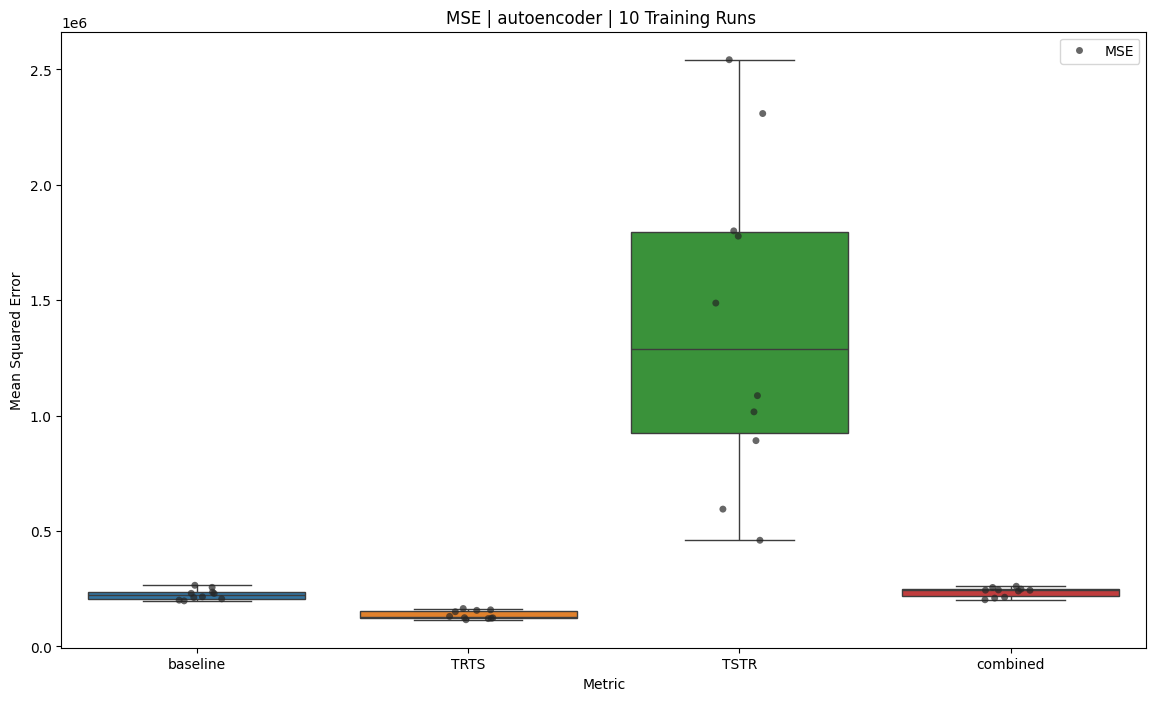

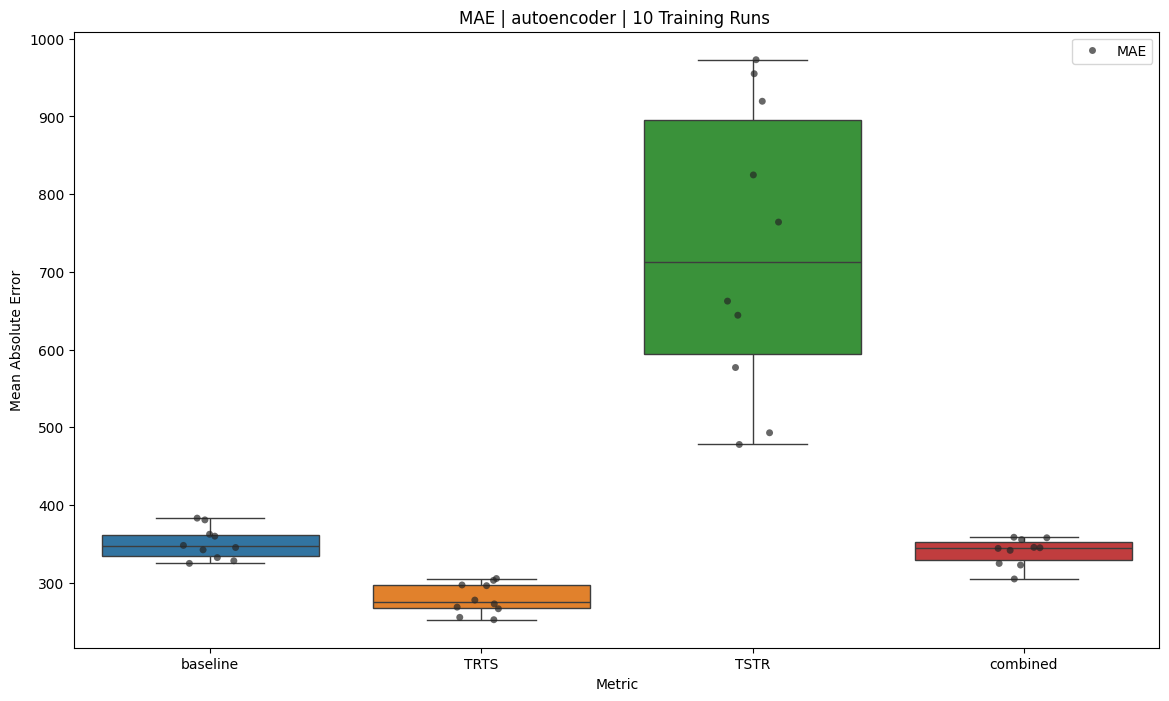

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [9]:
0.2*1e06

200000.0